# Predictive Analytics, Computer Vision & AI - CSC3831
## Coursework, Part 2: Machine Learning

As this coursework is as much about practical skills as it is about reflecting on the procedures and the results, you are expected to explain what you did, your reasoning for process decisions, as well as a thorough analysis of your results.


### 1. Load the MNIST dataset, visualise the first 20 digits, and print their corresponding labels.

In [2]:
# Run this to load the MNIST dataset
from sklearn.datasets import fetch_openml

X, y = fetch_openml(
    'mnist_784', version=1, return_X_y=True, parser='auto', as_frame=False
)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LogisticRegression,
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
)
from sklearn.naive_bayes import (
    GaussianNB,
)
from sklearn.neighbors import (
    KNeighborsClassifier,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import (
    DecisionTreeClassifier
)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA

seed = 64

In [3]:
def plot_digit(data, label):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=plt.cm.binary, interpolation="nearest")
    plt.title(label)
    plt.axis("off")

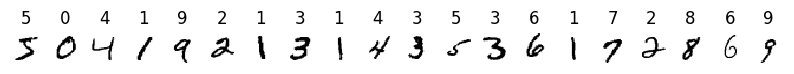

In [4]:
plt.figure(figsize=(10, 1))
for i in range(20):
    plt.subplot(1, 20, i + 1)
    plot_digit(X[i], y[i])
plt.show()

### 2. Train a Logistic Regression classifier on this data, and report on your findings.
    
1. Tune your hyperparameters to ensure *sparse* weight vectors and high accuracy.
2. Visualise the classification vector for each class.

To ensure sparse weight vectors, I added an L1 training penalty which reduces near-zero coefficients to zero, removing them from the model. To ensure high accuracy, I used a grid search to iterate over six preselected C values to find the optimal value.

In [ ]:
model = LogisticRegression(penalty="l1", solver="liblinear", random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=seed
)

hyperparams = [{
    "C": [0.001, 0.005, 0.01, 0.05, 0.1, 1]
}]

In [5]:
grid_search = GridSearchCV(model, hyperparams, cv=5)
grid_search.fit(X_train, y_train)

preds = grid_search.predict(X_test)
acc = accuracy_score(y_test, preds)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_}")
print(f"Test accuracy: {acc:.3f}")

Best parameters: {'C': 0.005}
Best CV score: 0.9160634920634919
Test accuracy: 0.922


From this, I have found that 0.005 is the best value for C, resulting in a test accuracy of approximately 92.2%

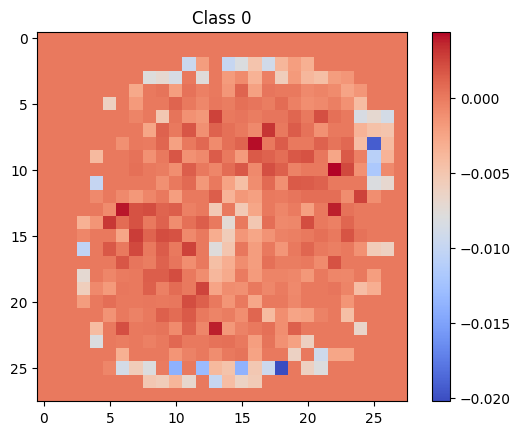

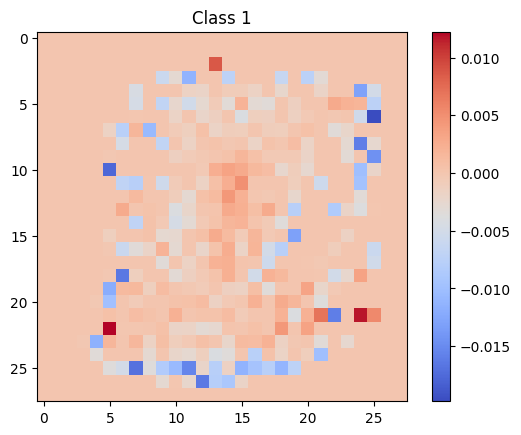

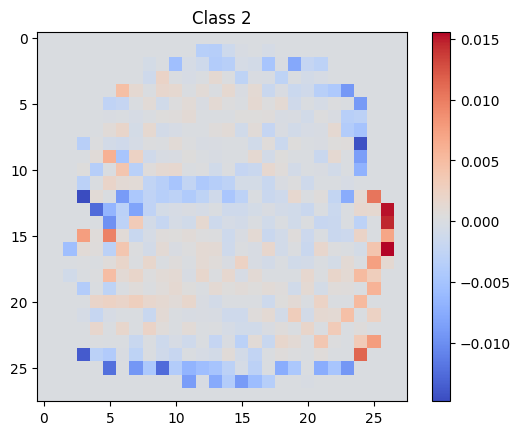

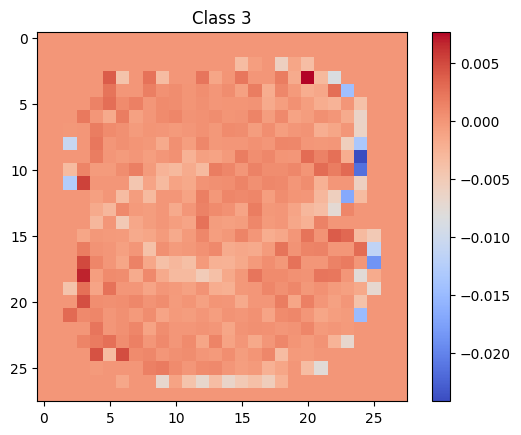

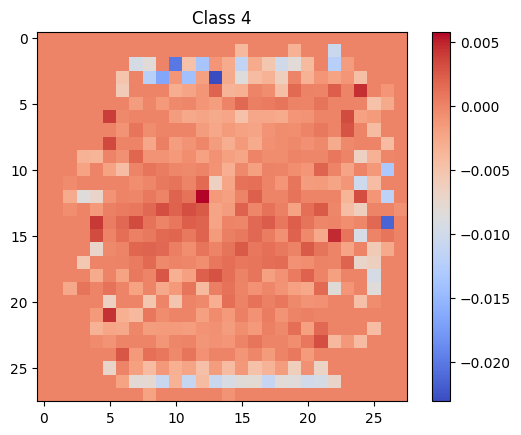

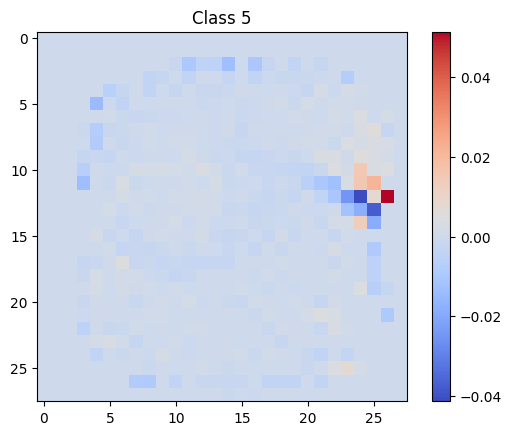

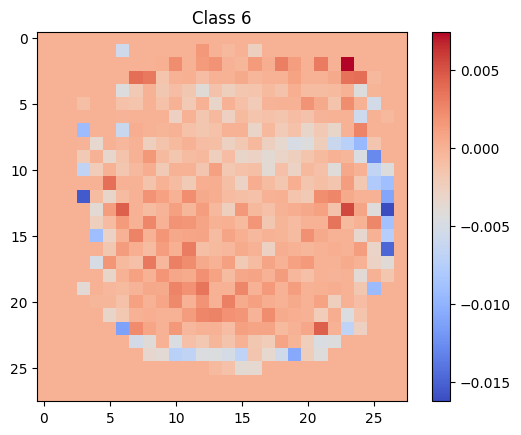

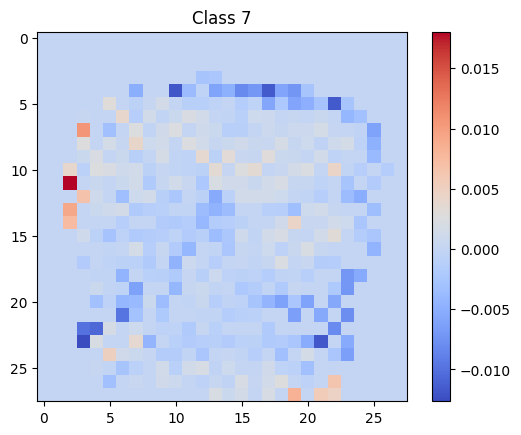

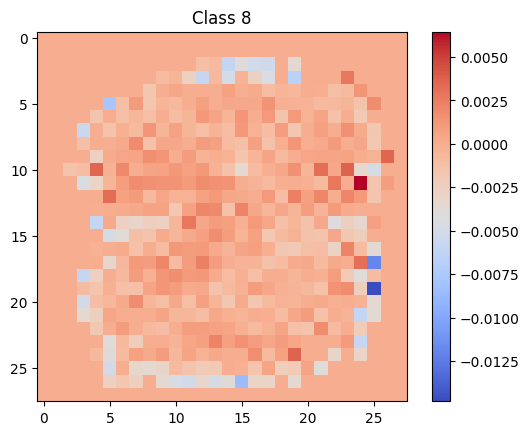

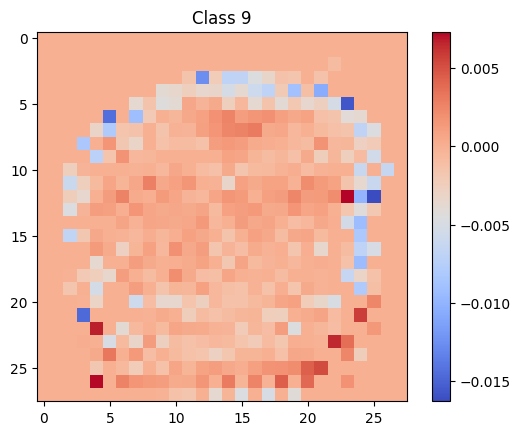

In [6]:
weights = grid_search.best_estimator_.coef_

for i, class_weight in enumerate(weights):
    plt.figure()
    plt.title(f"Class {i}")
    plt.imshow(class_weight.reshape(28,28), cmap="coolwarm")
    plt.colorbar()
    plt.show()

### 3. Use PCA to reduce the dimensionality of your training data.
    
1. Determine the number of components necessary to explain 80\% of the variance
2. Plot the explained variance by number of components.
3. Visualise the 20 principal components' loadings
4. Plot the two principal components for your data using a scatterplot, colouring by class. What can you say about this plot?
5. Visualise the first 20 digits, *generated from their lower-dimensional representation*.

#### Number of components to explain 80% variance

In [8]:
pca = PCA()
pca.fit(X_train)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components to explain 80% variance: {n_components_80}")

Number of components to explain 80% variance: 43


From fitting my data to a PCA algorithm, I have found that 80% of the variance in the data can be explained by 43 attributes. This is likely due to the PCA eliminating data that is unlikely to include the essential data resulting in a trend, for example pixels around the outside of the image will remain consistent despite the number written as the written number will be in the center of the image.

#### Plotting number of components against cumulative variance

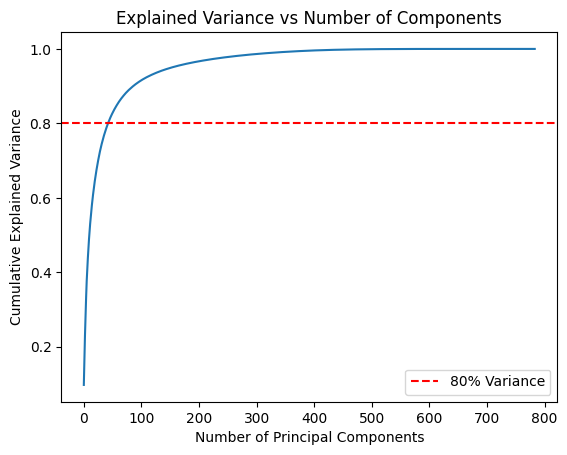

In [9]:
plt.figure()
plt.plot(cumulative_variance, marker='o', markersize=0)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.legend()
plt.show()

Here we can see a noticeable plateau of explained variance past around 100 attributes. Again, this is likely due to the same input values (pixels) consistently not holding any essential data that explains the variance.

#### Visualise the weights of each pixel for the first 20 digits

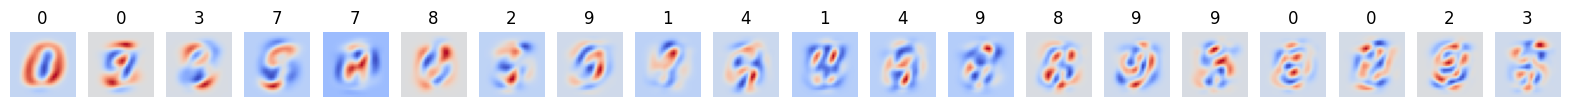

In [10]:
plt.figure(figsize=(20, 1))
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.imshow(pca.components_[i].reshape(28, 28), cmap="coolwarm")
    plt.title(y_train[i])
    plt.axis("off")
plt.show()


#### Plot the two principle components against eachother

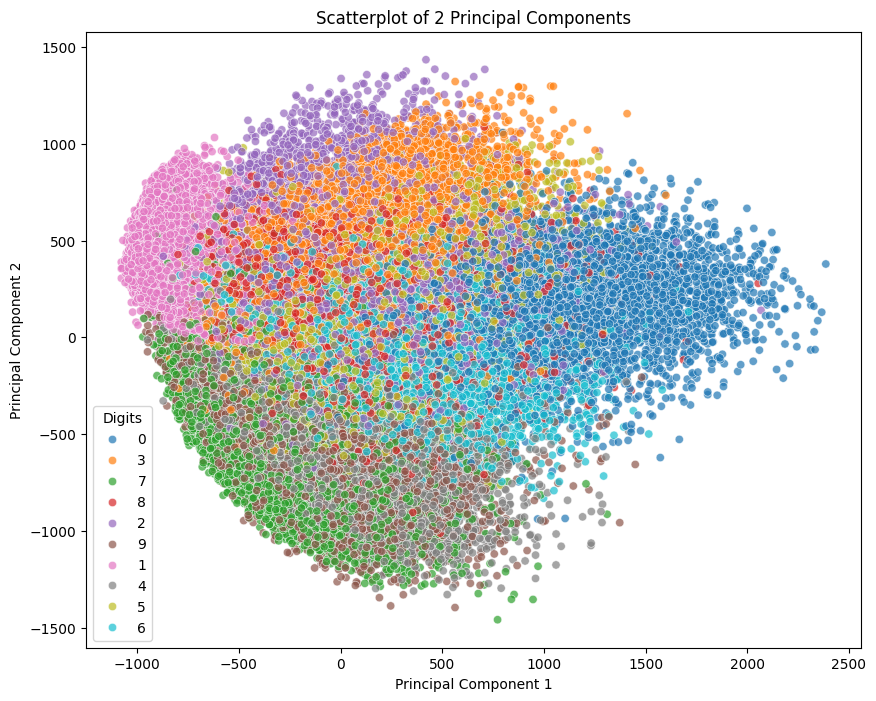

In [11]:
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train)

# Scatterplot of the two principal components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_train_2d[:, 0], y=X_train_2d[:, 1], hue=y_train, palette='tab10', legend='full', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot of 2 Principal Components')
plt.legend(loc='best', title='Digits')
plt.show()

#### Reconstructing the images from PCA

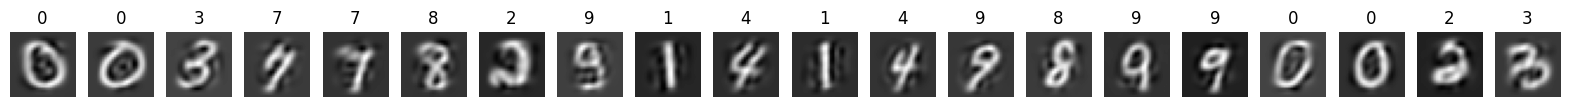

In [12]:
pca_reduced = PCA(n_components=n_components_80)
X_train_reduced = pca_reduced.fit_transform(X_train)
X_train_reconstructed = pca_reduced.inverse_transform(X_train_reduced)

plt.figure(figsize=(20, 1))
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.title(y_train[i])
    plt.imshow(X_train_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.show()


Here we can see that you are sill able to make out a most of the values after the data has been reconstructed. For more consistent accuracy, it may be helpful to have a higher threshold than 80%, however for most of the data to be retained and to act as a proof of concept, you can see that even after only 43 attributes were retained and the rest discarded, then the data being reconstructed, most of the data can still be identified.<br><br>

This would be very useful if you are training a complex model on a large dataset with a lot of attributes, as you would sill be able to retain most of the variance in the data with a significantly reduced input, making training large complex models much faster and easier.

### 4. Generate a noisy copy of your data by adding random normal noise to the digits **with a scale that doesn't completely destroy the signal**. This is, the resulting images noise should be apparent, but the numbers should still be understandable.
    
1. Visualise the first 20 digits from the noisy dataset.
2. Filter the noise by fitting a PCA explaining **a sufficient proportion** of the variance, and then transforming the noisy dataset. Figuring out this proportion is part of the challenge.
3. Visualise the first 20 digits of the de-noised dataset.

#### Add noise to dataset

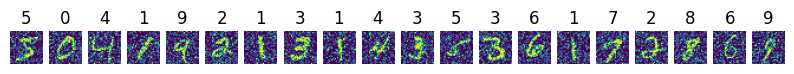

In [13]:
import skimage

X_noise = []

for i in range(len(X)):
    scaled = X[i] / 255.0
    X_noise.append(skimage.util.random_noise(scaled, mode="gaussian", var=0.175))

plt.figure(figsize=(10,1))
# plt.imshow(X[0].reshape(28,28))

for i in range(20):
    plt.subplot(1,20,i+1)
    plt.imshow(X_noise[i].reshape(28,28))
    plt.title(y[i])
    plt.axis("off")
plt.show()


#### Fit to PCA

To determine a sufficient proportion of variance, I have generated 20 different reduced datasets and analysed their performance on a logistic regression model to see what an appropriate threshold for variance would be. I tested values from 5% to 95% in 5% steps.

Variance: 5%
Number of components: 2
Accuracy: 0.43114285714285716


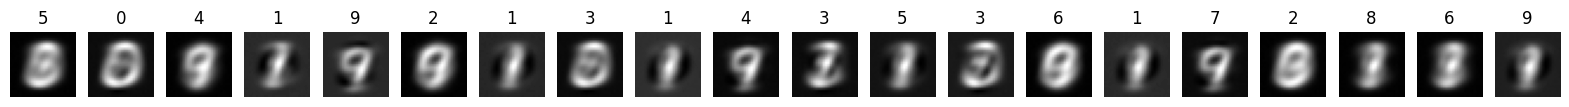

Variance: 10%
Number of components: 5
Accuracy: 0.6502857142857142


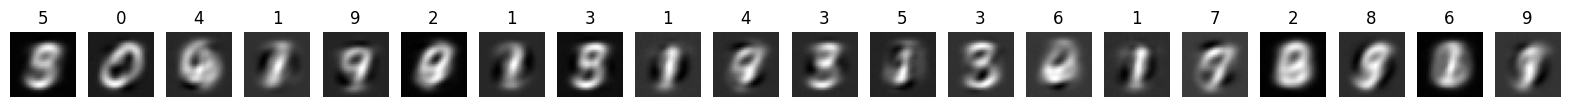

Variance: 15%
Number of components: 8
Accuracy: 0.7590285714285714


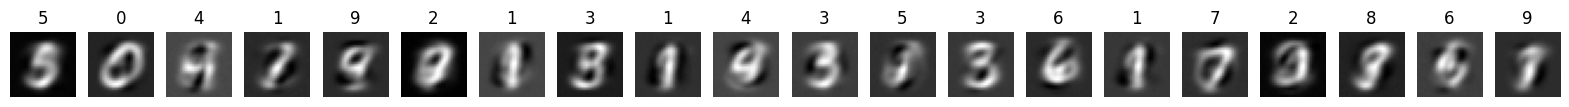

Variance: 20%
Number of components: 14
Accuracy: 0.8057142857142857


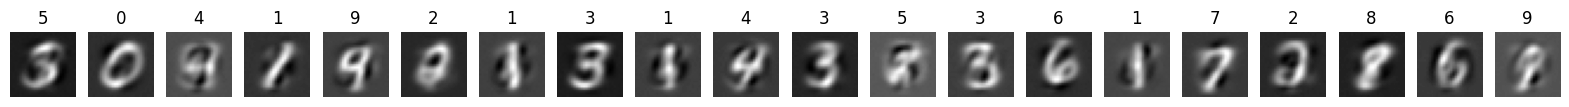

Variance: 25%
Number of components: 25
Accuracy: 0.8523428571428572


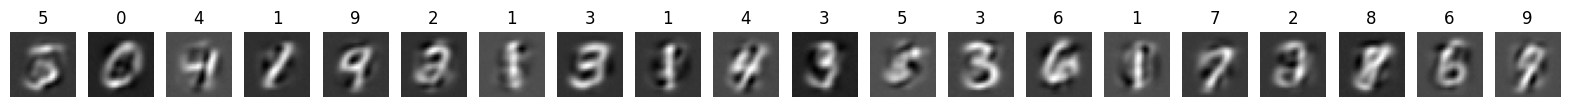

Variance: 30%
Number of components: 41
Accuracy: 0.8674285714285714


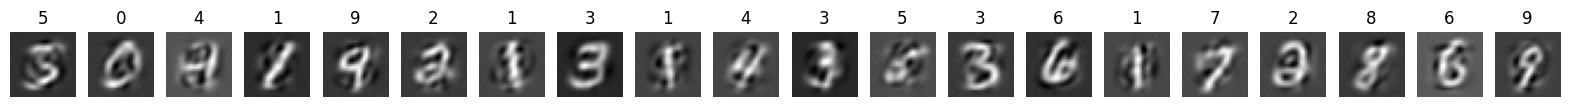

Variance: 35%
Number of components: 67
Accuracy: 0.8723428571428572


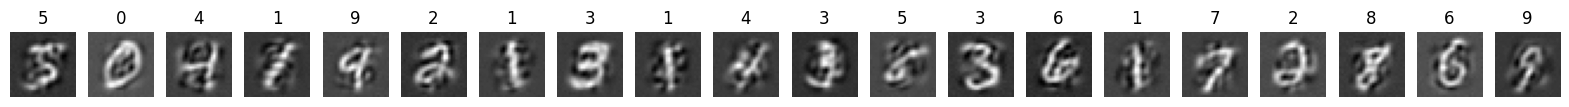

Variance: 40%
Number of components: 103
Accuracy: 0.8734285714285714


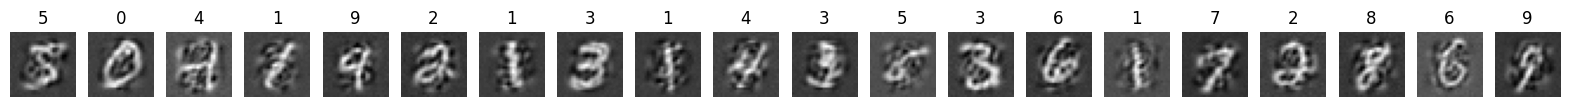

Variance: 45%
Number of components: 145
Accuracy: 0.8718285714285714


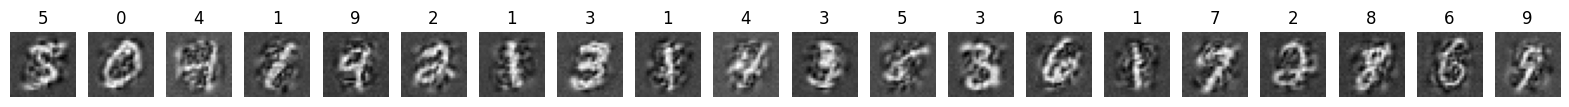

Variance: 50%
Number of components: 191
Accuracy: 0.8670857142857142


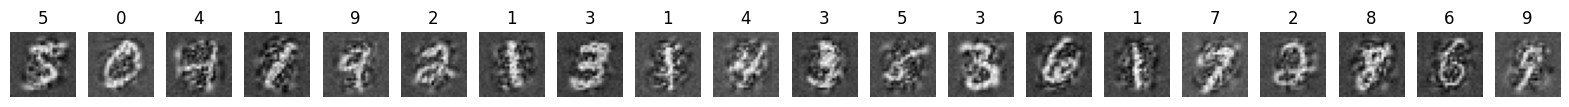

Variance: 55%
Number of components: 240
Accuracy: 0.8706857142857143


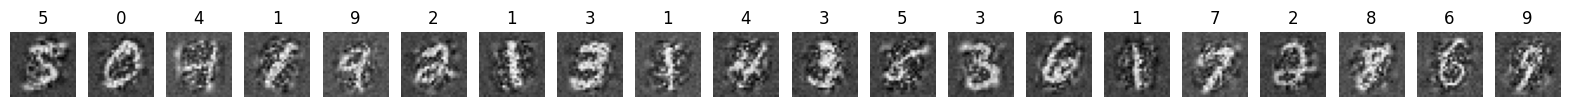

Variance: 60%
Number of components: 291
Accuracy: 0.8672571428571428


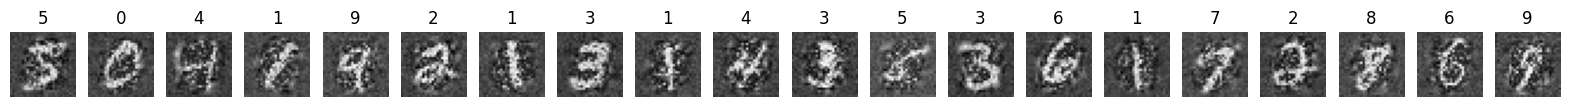

Variance: 65%
Number of components: 344
Accuracy: 0.8665142857142857


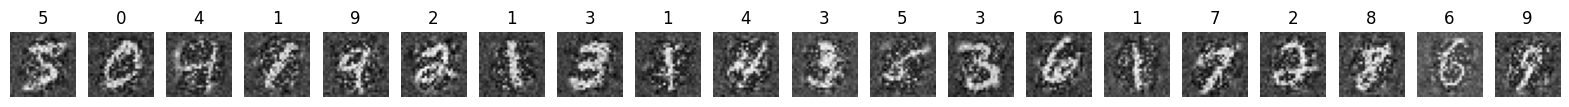

Variance: 70%
Number of components: 400
Accuracy: 0.8650857142857142


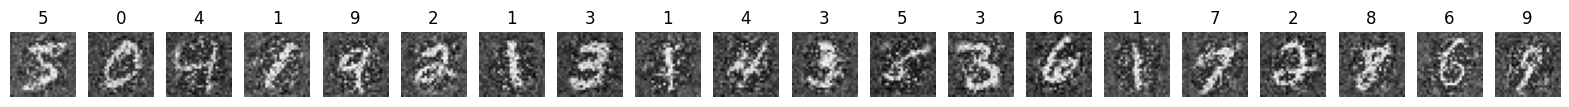

Variance: 75%
Number of components: 458
Accuracy: 0.8602857142857143


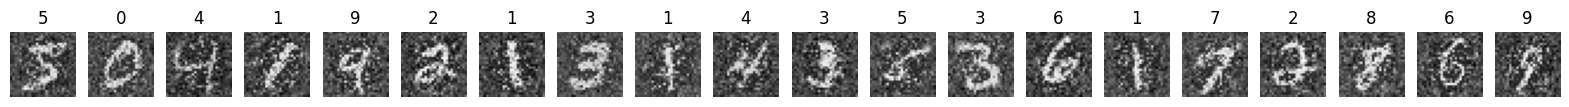

Variance: 80%
Number of components: 519
Accuracy: 0.8630857142857142


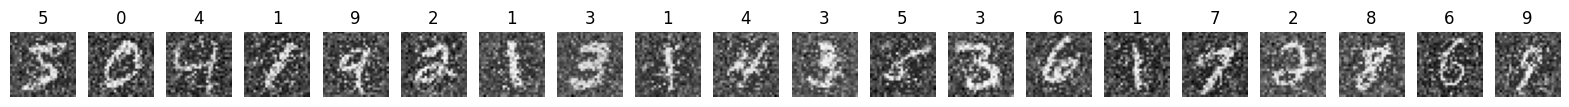

Variance: 85%
Number of components: 581
Accuracy: 0.8598285714285714


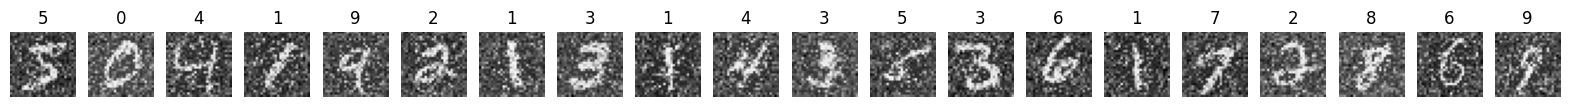

Variance: 90%
Number of components: 646
Accuracy: 0.8593714285714286


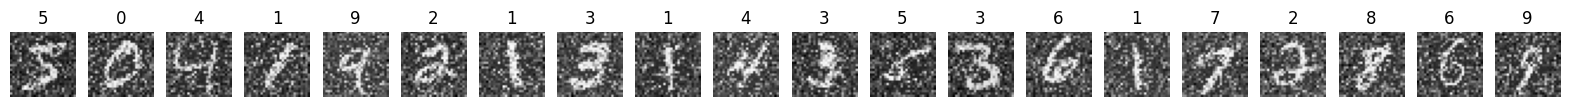

Variance: 95%
Number of components: 713
Accuracy: 0.8564


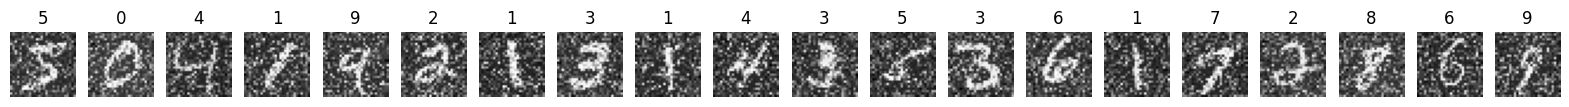

In [14]:
pca = PCA()
pca.fit(X_noise)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

cum_variance = []
accuracy = []

for i in range(1, 20):
    n = np.argmax(cumulative_variance >= i/20) + 1
    pca_reduced = PCA(n_components=n)
    X_noise_reduced = pca_reduced.fit_transform(X_noise)
    X_noise_reconstructed = pca_reduced.inverse_transform(X_noise_reduced)

    model = LogisticRegression()
    X_noise_reduced_train, X_noise_reduced_test, y_train, y_test = train_test_split(X_noise_reduced, y)
    model.fit(X_noise_reduced_train, y_train)

    preds = model.predict(X_noise_reduced_test)
    acc = accuracy_score(preds, y_test)

    print(f"Variance: {i*5}%")
    print(f"Number of components: {n}")
    print(f"Accuracy: {acc}")

    cum_variance.append(i*5)
    accuracy.append(acc)

    plt.figure(figsize=(20, 1))
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.title(y[i])
        plt.imshow(X_noise_reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis("off")
    plt.show()

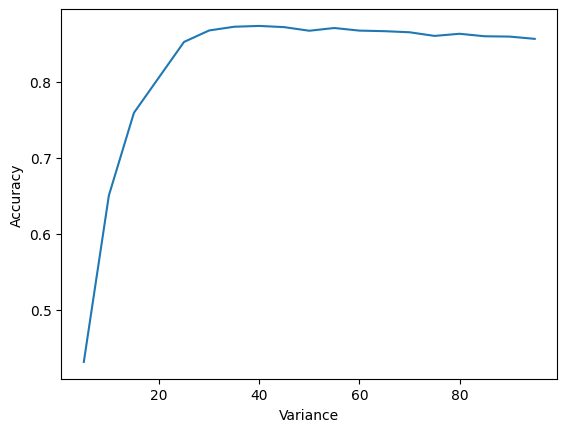

In [15]:
plt.figure()
plt.plot(cum_variance, accuracy)
plt.xlabel("Variance")
plt.ylabel("Accuracy")
plt.show()

This graph shows that the model didn't show any sign of improvement after retaining 25% of variance, meaning if you wanted to train a model on this dataset, the most appropriate variance threshold would be somewhere around the 25% mark.

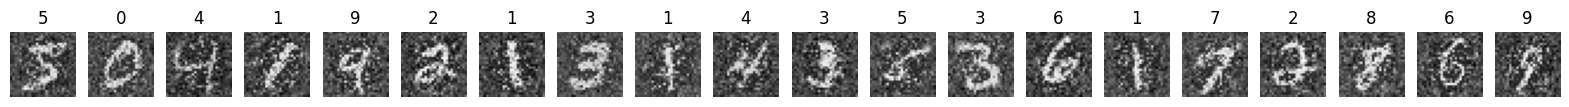

In [17]:
n = np.argmax(cumulative_variance >= 0.75) + 1
pca_reduced = PCA(n_components=n)
X_noise_reduced = pca_reduced.fit_transform(X_noise)
X_noise_reconstructed = pca_reduced.inverse_transform(X_noise_reduced)

plt.figure(figsize=(20, 1))
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.title(y[i])
    plt.imshow(X_noise_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.show()

I used a threshold of 75% as I found that despite the model performing well at classifying the values after retaining only 25% of the variance, I found it quite difficult to identify the numbers at any lower variance than 70-75%. This means if you want to use a PCA algorithm on your data, you need to consider what you are using the algorithm for and how different models perform at different variance levels.